# Image Captioning이란?


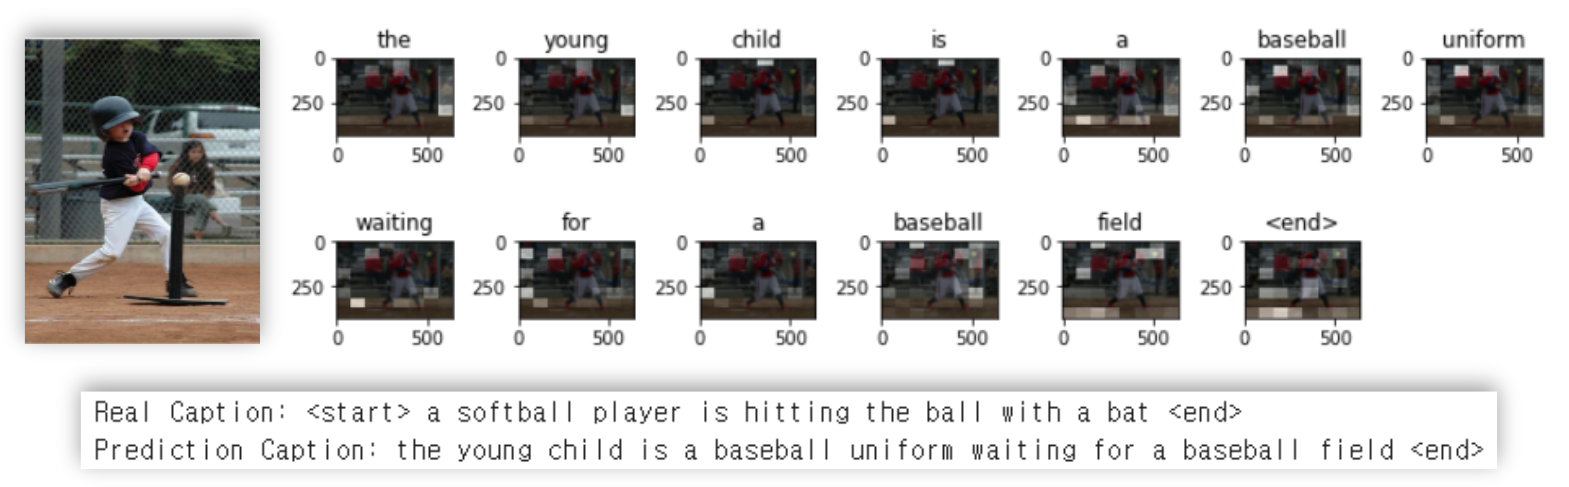

이미지 캡셔닝은 이미지가 지닌 정보를 설명해주는 한 문장을 설명하는 기술입니다.이미지 캡셔닝은 영상, 이미지를 처리하는 컴퓨터 비전, 그리고 자연어 처리라는 인공지능의 큰 축인 두 분야를 연결해주는 중요한 의의를 갖는 연구입니다. 기존의 주어진 연구들은 주로 이미지를 입력받아 영어 문장을 생성해냈다면, 저희는 이를 한국어로 문장을 생성하고자 합니다

이 모델은  [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044) 논문을 기반으로 합니다.

이 노트북 파일은 End-To-End 파일입니다. [MS COCO 2014 Dataset](https://cocodataset.org/#download)을 프로그램에서 자체적으로 다운로드하고, [AI HUB에서 제공한 한국어 Annotation File을 (편집 과정을 일부 거쳤음)](https://aihub.or.kr/keti_data_board/visual_intelligence_)을 이용자가 직접 업로드하면, Resnet-101을 이용해 이미지를 전처리 및 캐시 처리한 후, 추출해낸 Feature 값을 LSTM에 입력해 모델을 훈련합니다. 훈련된 모델을 활용해 새로운 이미지에 대한 캡션을 생성하고, 이를 BLEU 기준을 통해 평가하는 것까지가 하나의 프로그램이 될 것입니다. 




---
# Image-captioning-pepper_prototype

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import pandas as pd
import os
import time
import json
from PIL import Image
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

plt.rc('font', family = 'NanumBarunGothic')

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())

2.8.0
True
True
/device:GPU:0


# Pepper Dataset

만일 Local PC에서 이 프로그램을 동작시킬 경우, annotation_file에 'captions_kor_train.json' 파일의 경로를 입력해주어 연결시켜줍니다.

In [9]:
image_folder ='C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_disease_images/'
PATH = image_folder

In [14]:
annotations = pd.read_csv("C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/pepper_disease.csv", encoding='cp949')
annotations.head()

,images,captions
0,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다
1,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다
2,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다
3,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다
4,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다


### Group all captions together having the same image ID.
* `<start> <end>` 붙여주기
* `image_path` 정의
* `image_path_to_caption` 정의

In [15]:
annotations['captions'] = annotations['captions'].apply(lambda x: '<start> ' + x + ' <end>')
annotations.head()

,images,captions
0,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 ...
1,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니...
2,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>
3,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>
4,V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG,<start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다...


In [16]:
print(len(annotations))

100680


* defualtdictionary 형식의 image_path_to_caption 에 (key)1개 이미지 경로 당, (values)5개 caption을 한 리스트로 생성  

In [17]:
image_path_to_caption = collections.defaultdict(list)
for i in range(len(annotations)):
    image_path = PATH + annotations.images[i]
#     print(image_path, '\n')
    image_path_to_caption[image_path].append(annotations.captions[i])
#     print(image_path_to_caption)
print(image_path)
print(image_path_to_caption[image_path])

C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_disease_images/V006_79_1_02_01_03_13_3_9315z_20201126_9_a0009.JPG
['<start> 고추에 잎에 담황색 병무늬와 밀가루 바른 것과 같은 증상이 넓게 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 담황색 반점무늬와 연한 흰색 곰팡이가 잎에 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 서릿발 모양의 포자가 넓게 나타나고 담황색 병무늬가 발견되어 고추흰가루병으로 사료됩니다 <end>', '<start> 고추에 잎에 이슬과 같은 연한 흰색 곰팡이가 보이고 담황색 반점무늬가 발견되어 고추흰가루병으로 사료됩니다 <end>', '<start> 고추에 밀가루를 바른 것과 같은 포자가 넓게 나타나고 담황색 병무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>']


In [18]:
print(image_path_to_caption)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



* train_image_paths 에 image 들의 이름(key)들만을 리스트로 정의 
    * shuffle 로 섞어주기
* *용량 제한*을 두어 30,000개의 캡션(6,000개의 이미지)만 사용 가능
    * ex) `train_image_paths = image_paths[:6000]`

In [19]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths #[:6000]
print(len(train_image_paths))
# print(train_image_paths)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    print(image_path_to_caption[image_path],'\n')
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
#     print(len(caption_list))
    img_name_vector.extend([image_path] * len(caption_list))
# print(img_name_vector)

['<start> 고추에 얇은 서릿발 모양의 포자가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 얇은 서릿발 모양의 곰팡이가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 이슬과 같은 연한 흰색 곰팡이가 발견되어 고추흰가루병으로 사료됩니다 <end>', '<start> 고추에 이슬과 같은 포자가 발견되어 고추흰가루병으로 사료됩니다 <end>', '<start> 고추에 얇은 서릿발 모양의 포자와 이슬과 같은 연한 흰색 곰팡이가 발견되어 고추흰가루병으로 의심됩니다 <end>'] 

['<start> 고추에 잎에 담황색 병무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 잎에 담황색 반점무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 서릿발 모양의 포자와 담황색 병무늬가 발견되어 고추흰가루병으로 사료됩니다 <end>', '<start> 고추에 이슬과 같은 연한 흰색 곰팡이와 담황색 반점무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 밀가루를 바른 것과 같은 포자와 담황색 병무늬가 발견되어 보아 고추흰가루병으로 의심됩니다 <end>'] 

['<start> 고추에 잎에 담황색 병무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 잎에 담황색 반점무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 서릿발 모양의 포자와 담황색 병무늬가 발견되어 고추흰가루병으로 사료됩니다 <end>', '<start> 고추에 이슬과 같은 연한 흰색 곰팡이와 담황색 반점무늬가 발견되어 고추흰가루병으로 의심됩니다 <end>', '<start> 고추에 밀가루를 바른 것과 같은 포자와 담황색 병무늬가 발견되어 보아 고추흰가루병으로 의심됩니다 <end>'] 

['<start> 얇은 서릿발 모양의 포자가 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 얇은 서릿발

['<start> 잎에 담황색 병무늬와 밀가루 바른 것과 같은 증상이 넓게 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 담황색 반점무늬와 연한 흰색 곰팡이가 잎에 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 서릿발 모양의 포자가 넓게 나타나고 담황색 병무늬가 나타나는 것으로 보아 고추흰가루병으로 사료됩니다 <end>', '<start> 잎에 이슬과 같은 연한 흰색 곰팡이가 보이고 담황색 반점무늬가 나타나는 것으로 보아 고추흰가루병으로 사료됩니다 <end>', '<start> 밀가루를 바른 것과 같은 포자가 넓게 나타나고 담황색 병무늬가 보이는 것으로 보아 고추흰가루병으로 의심됩니다 <end>'] 

['<start> 얇은 서릿발 모양의 포자가 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 얇은 서릿발 모양의 곰팡이가 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 이슬과 같은 연한 흰색 곰팡이가 나타나는 것으로 보아 고추흰가루병으로 사료됩니다 <end>', '<start> 이슬과 같은 포자가 나타나는 곳으로 보아 고추흰가루병으로 사료됩니다 <end>', '<start> 얇은 서릿발 모양의 포자와 이슬과 같은 연한 흰색 곰팡이가 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>'] 

['<start> 잎에 담황색 병무늬와 밀가루 바른 것과 같은 증상이 넓게 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 담황색 반점무늬와 연한 흰색 곰팡이가 잎에 나타나는 것으로 보아 고추흰가루병으로 의심됩니다 <end>', '<start> 서릿발 모양의 포자가 넓게 나타나고 담황색 병무늬가 나타나는 것으로 보아 고추흰가루병으로 사료됩니다 <end>', '<start> 잎에 이슬과 같은 연한 흰색 곰팡이가 보이고 담황색 반점무늬가 나타나는 것으로 보아 고추흰가루병으로 사료됩니다 <end>', '<start> 밀

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## ResNet101 사용하여 이미지 전처리하기

다음으로, (Imagenet에 대해 사전 훈련된) ResNet101을 사용하여 이미지를 분류하고 마지막 Convolutional Layer에서 특징을 추출해냅니다.

- 이미지를 299px x 299px로 resize합니다.
- [ResNet101 설명](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101)

In [21]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

## ResNet101 초기화 및 사전 훈련된 Imagenet 가중치 로드하기

이제 Output Layer가 InceptionV3의 마지막 Convolutional Layer인 tf.keras 모델을 만듭니다.

- 네트워크를 통해 각 이미지를 전달하고 결과 벡터를 사전 (image_name --&gt; feature_vector)에 저장합니다.
- 모든 이미지가 네트워크를 통해 전달된 후, 사전을 디스크에 저장합니다.

In [22]:
image_model = tf.keras.applications.ResNet101(include_top=False,
                                                weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [23]:
print(image_features_extract_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

## ResNet101에서 추출된 특성 캐시하기

ResNet101로 각 이미지를 사전 처리하고 출력을 디스크에 캐시합니다. 현재 코드보다 정교한 캐싱 전략(ex. 임의 액세스 디스크 I/O를 줄이기 위해 이미지 분할 등)으로 성능을 향상할 수 있습니다.


In [24]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## 캡션 전처리 및 토큰화하기

- 캡션을 토큰화합니다. 그리고 최대 단어의 크기를 상위 10,000개 단어로 제한합니다. 
그 단어 이외의 단어들은 토큰 "UNK"(알 수 없음)로 대체됩니다.
- 그 후, 단어 대 인덱스 및 인덱스 대 단어 매핑을 만듭니다.
- 마지막으로, 모든 시퀀스를 가장 긴 시퀀스와 같은 길이로 채웁니다.

In [25]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [26]:
print(train_captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
# Choose the top 10,000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
# print(train_captions)

In [29]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '포자덩어리와': 20, '움푹': 21, '병무늬가': 22, '들어간': 23, '반점이': 24, '잎에': 25, '포자와': 26, '포자덩어리가': 27, '사료됩니다': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '서릿발': 33, '모양의': 34, '이슬과': 35, '원형반점이': 36, '곰팡이가': 37, '것을': 38, '반점무늬가': 39, '바른': 40, '것과': 41, '생긴': 42, '나타나며': 43, '넓게': 44, '고추가': 45, '원형반점과': 46, '밀가루를': 47, '얇은': 48, '비틀어지고': 49, '보여': 50, '말라비틀어진': 51, '고추탄저병이': 52, '곰팡이와': 53, '병무늬와': 54, '밀가루': 55, '증상이': 56, '반점무늬와': 57, '보이고': 58, '생겼고': 59, '보이는': 60, '발견되므로': 61, '곳으로': 62, '고추에서': 63, '들어나는': 64, '양상을': 65, '나타나므로': 66, '확인할': 67, '수': 68, '있어': 69, '드러나므로': 70, '확인되므로': 71, '나타나': 72}


In [30]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [31]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '의심됩니다', 5: '보아', 6: '것으로', 7: '고추에', 8: '고추탄저병으로', 9: '고추흰가루병으로', 10: '담황색', 11: '원형', 12: '말라', 13: '비틀어진', 14: '나타나고', 15: '발견되어', 16: '황갈색의', 17: '황갈색', 18: '같은', 19: '나타나는', 20: '포자덩어리와', 21: '움푹', 22: '병무늬가', 23: '들어간', 24: '반점이', 25: '잎에', 26: '포자와', 27: '포자덩어리가', 28: '사료됩니다', 29: '포자가', 30: '반점과', 31: '연한', 32: '흰색', 33: '서릿발', 34: '모양의', 35: '이슬과', 36: '원형반점이', 37: '곰팡이가', 38: '것을', 39: '반점무늬가', 40: '바른', 41: '것과', 42: '생긴', 43: '나타나며', 44: '넓게', 45: '고추가', 46: '원형반점과', 47: '밀가루를', 48: '얇은', 49: '비틀어지고', 50: '보여', 51: '말라비틀어진', 52: '고추탄저병이', 53: '곰팡이와', 54: '병무늬와', 55: '밀가루', 56: '증상이', 57: '반점무늬와', 58: '보이고', 59: '생겼고', 60: '보이는', 61: '발견되므로', 62: '곳으로', 63: '고추에서', 64: '들어나는', 65: '양상을', 66: '나타나므로', 67: '확인할', 68: '수', 69: '있어', 70: '드러나므로', 71: '확인되므로', 72: '나타나', 0: '<pad>'}


In [32]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [33]:
print(train_seqs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# print(cap_vector)

In [35]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## 데이터를 훈련(Train) 및 평가(Validation) 데이터셋로 분할하기




In [36]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80:20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

## 훈련을 위한 tf.data 데이터세트 생성하기


이미지와 캡션이 준비되었습니다. 다음으로 모델 훈련에 사용할 `tf.data` 데이터세트를 만듭니다.

In [37]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from ResNet101 is (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [38]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 모델

모델은 Encoder로 CNN을 Decoder로 RNN을 활용합니다. 
- CNN에서는 이미지의 Feature들을 추출해낸 후, 
- 추출한 Feature들을 RNN을 통해서 단어 토큰으로 출력하는 구조로 이루어집니다. 

In [40]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 100, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 100, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 100, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 100, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [41]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 100, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [42]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 체크포인트

In [45]:
checkpoint_path = "./checkpoints_pepper_prototype/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [46]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## 훈련하기

- 각 `.npy` 파일에 저장된 특성을 추출한 다음, 해당 특성을 endcoder를 통해 전달합니다.
- encoder의 출력값, decoder의 hidden state(0으로 초기화됨) 및 입력값(start token)이 decoder로 전달됩니다.
- decoder는 예측값 및 decoder hidden state를 반환합니다.
- 그 후 decoder hidden state가 모델로 다시 전달되고, 예측값은 손실을 계산하는 데 사용됩니다. 
- teacher forcing를 사용하여 decoder에 대한 다음 입력을 결정합니다. teacher forcing은 출력값이, 다음 입력값으로 decoder에 전달되는 기법입니다.
- 마지막으로 Gradient를 계산하고 이를 Optimizer에 적용하여 Back-propagation합니다.


In [47]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [48]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '포자덩어리와': 20, '움푹': 21, '병무늬가': 22, '들어간': 23, '반점이': 24, '잎에': 25, '포자와': 26, '포자덩어리가': 27, '사료됩니다': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '서릿발': 33, '모양의': 34, '이슬과': 35, '원형반점이': 36, '곰팡이가': 37, '것을': 38, '반점무늬가': 39, '바른': 40, '것과': 41, '생긴': 42, '나타나며': 43, '넓게': 44, '고추가': 45, '원형반점과': 46, '밀가루를': 47, '얇은': 48, '비틀어지고': 49, '보여': 50, '말라비틀어진': 51, '고추탄저병이': 52, '곰팡이와': 53, '병무늬와': 54, '밀가루': 55, '증상이': 56, '반점무늬와': 57, '보이고': 58, '생겼고': 59, '보이는': 60, '발견되므로': 61, '곳으로': 62, '고추에서': 63, '들어나는': 64, '양상을': 65, '나타나므로': 66, '확인할': 67, '수': 68, '있어': 69, '드러나므로': 70, '확인되므로': 71, '나타나': 72, '<pad>': 0}


In [49]:
print(tokenizer.word_index['<unk>'])

1


In [50]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
#     print(tokenizer.word_index)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

- Epoch는 다음 학습을 몇 번 반복할 지를 결정합니다. 
- Default 값으로는 20번으로 지정되어있습니다.
- 이용자가 원하는 만큼 지정해서 성능을 향상시킵니다.

In [51]:
from tqdm import tqdm
import time

EPOCHS = 20
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 6.5685
Epoch 1 Batch 100 Loss 2.2839
Epoch 1 Batch 200 Loss 0.5067
Epoch 1 Batch 300 Loss 0.3726
Epoch 1 Batch 400 Loss 0.3405
Epoch 1 Batch 500 Loss 0.2913
Epoch 1 Batch 600 Loss 0.2630
Epoch 1 Batch 700 Loss 0.2613
Epoch 1 Batch 800 Loss 0.2550
Epoch 1 Batch 900 Loss 0.2094
Epoch 1 Batch 1000 Loss 0.2274
Epoch 1 Batch 1100 Loss 0.2107
Epoch 1 Batch 1200 Loss 0.2333
Epoch 1 Loss 0.518781
Time taken for 1 epoch 107.28 sec

Epoch 2 Batch 0 Loss 0.2338
Epoch 2 Batch 100 Loss 0.1894
Epoch 2 Batch 200 Loss 0.1799
Epoch 2 Batch 300 Loss 0.1947
Epoch 2 Batch 400 Loss 0.1768
Epoch 2 Batch 500 Loss 0.1906
Epoch 2 Batch 600 Loss 0.1525
Epoch 2 Batch 700 Loss 0.1681
Epoch 2 Batch 800 Loss 0.1781
Epoch 2 Batch 900 Loss 0.1505
Epoch 2 Batch 1000 Loss 0.1562
Epoch 2 Batch 1100 Loss 0.1405
Epoch 2 Batch 1200 Loss 0.1392
Epoch 2 Loss 0.173058
Time taken for 1 epoch 98.86 sec

Epoch 3 Batch 0 Loss 0.1763
Epoch 3 Batch 100 Loss 0.1465
Epoch 3 Batch 200 Loss 0.1261
Epoch 3 Batch 300

Epoch 19 Batch 100 Loss 0.1068
Epoch 19 Batch 200 Loss 0.1076
Epoch 19 Batch 300 Loss 0.1061
Epoch 19 Batch 400 Loss 0.1069
Epoch 19 Batch 500 Loss 0.1056
Epoch 19 Batch 600 Loss 0.1019
Epoch 19 Batch 700 Loss 0.1023
Epoch 19 Batch 800 Loss 0.1054
Epoch 19 Batch 900 Loss 0.1071
Epoch 19 Batch 1000 Loss 0.1075
Epoch 19 Batch 1100 Loss 0.1059
Epoch 19 Batch 1200 Loss 0.1064
Epoch 19 Loss 0.106589
Time taken for 1 epoch 87.60 sec

Epoch 20 Batch 0 Loss 0.1060
Epoch 20 Batch 100 Loss 0.1194
Epoch 20 Batch 200 Loss 0.1050
Epoch 20 Batch 300 Loss 0.1064
Epoch 20 Batch 400 Loss 0.1028
Epoch 20 Batch 500 Loss 0.1056
Epoch 20 Batch 600 Loss 0.1059
Epoch 20 Batch 700 Loss 0.1028
Epoch 20 Batch 800 Loss 0.1044
Epoch 20 Batch 900 Loss 0.1090
Epoch 20 Batch 1000 Loss 0.1066
Epoch 20 Batch 1100 Loss 0.1079
Epoch 20 Batch 1200 Loss 0.1092
Epoch 20 Loss 0.106545
Time taken for 1 epoch 87.32 sec



In [52]:
print(loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.5187815>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17305821>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13794036>, <tf.Tensor: shape=(), dtype=float32, numpy=0.124350786>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11871564>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11889863>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11233014>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11303587>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11150758>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11068633>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11043736>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10797413>, <tf.Tensor: shape=(), dtype=float32, numpy=0.112345986>, <tf.Tensor: shape=(), dtype=float32, numpy=0.107167155>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10700898>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10723861>, <tf.Tensor: shape=(), dtype=float32, numpy=0.107501976>, <tf.Tensor: shape=(), dtype=float32, numpy=0

In [53]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
### val epoch
val_loss_plot = []
start_epoch = 0
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    val_loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.2101
Epoch 1 Batch 100 Loss 0.1545
Epoch 1 Batch 200 Loss 0.1338
Epoch 1 Batch 300 Loss 0.1483
Epoch 1 Loss 0.037634
Time taken for 1 epoch 28.75 sec

Epoch 2 Batch 0 Loss 0.1225
Epoch 2 Batch 100 Loss 0.1068
Epoch 2 Batch 200 Loss 0.1215
Epoch 2 Batch 300 Loss 0.1056
Epoch 2 Loss 0.028242
Time taken for 1 epoch 22.21 sec

Epoch 3 Batch 0 Loss 0.1132
Epoch 3 Batch 100 Loss 0.1075
Epoch 3 Batch 200 Loss 0.1059
Epoch 3 Batch 300 Loss 0.1046
Epoch 3 Loss 0.026591
Time taken for 1 epoch 21.74 sec

Epoch 4 Batch 0 Loss 0.1095
Epoch 4 Batch 100 Loss 0.1038
Epoch 4 Batch 200 Loss 0.1052
Epoch 4 Batch 300 Loss 0.1194
Epoch 4 Loss 0.026261
Time taken for 1 epoch 21.68 sec

Epoch 5 Batch 0 Loss 0.1046
Epoch 5 Batch 100 Loss 0.1076
Epoch 5 Batch 200 Loss 0.1027
Epoch 5 Batch 300 Loss 0.1050
Epoch 5 Loss 0.026104
Time taken for 1 epoch 21.82 sec

Epoch 6 Batch 0 Loss 0.1007
Epoch 6 Batch 100 Loss 0.1054
Epoch 6 Batch 200 Loss 0.1024
Epoch 6 Batch 300 Loss 0.1064
Epoch 6 Loss

In [55]:
print(val_loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.037633773>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028241642>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026590766>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026260655>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026103737>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026025148>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02608245>, <tf.Tensor: shape=(), dtype=float32, numpy=0.025920086>, <tf.Tensor: shape=(), dtype=float32, numpy=0.025905985>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02835788>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027190268>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026981503>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027041964>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026847593>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026579527>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026696859>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026511034>, <tf.Tensor: shape=(), dtype=floa

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


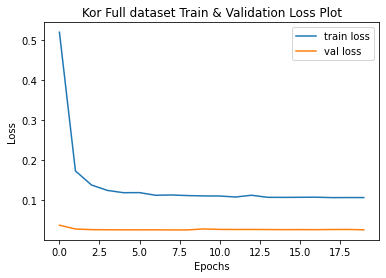

In [56]:
# Train & Validation Loss Plot
plt.plot(loss_plot, label = 'train loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Kor Full dataset Train & Validation Loss Plot')
plt.legend()
plt.show()

## 캡셔닝

- 각 타임스텝에서 decoder는 Decoder의 hidden state, encoder 출력값 그리고 이전 예측값을 입력값으로 받습니다.
- 모델이 end 토큰을 예측하면 예측이 중지됩니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [57]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [58]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        
        #grid_size = max(np.ceil(len_result/2), 2)
        grid_size = max(np.ceil(len_result/4), 4)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.5, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# TEST 단계


Test를 수행하기 위한 MS-COCO 2014 Validation set을 다운로드합니다.

 그리고 annotation_file 에 이전에 train caption file의 경로를 지정했듯, val caption file의 경로를 지정합니다

# 추가 실험
- 이 모델에게 새로운 이미지를 주고, 제대로 학습이 이루어졌는지 확인해봅시다. 
- 물론, Dataset 이외의 데이터를 주게 되면, 실험 결과가 부정확할 확률이 높지만, 재미로 해봅시다. 
- 아래 URL을 바꾸면 이미지를 바꿀 수 있습니다. 

In [61]:
image_url = 'https://mblogthumb-phinf.pstatic.net/20160326_90/secure2000_1458994420780pXbGw_JPEG/20160325_153422.jpg?type=w2'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

180224/169680 [===============================] - 0s 0us/step
C:\Users\DI Lee\.keras\datasets\imagee=w2
Prediction Caption: 서릿발 모양의 포자가 넓게 나타나고 담황색 병무늬가 나타나는 것으로 보아 고추흰가루병으로 사료됩니다 <end>


ValueError: Number of rows must be a positive integer, not 4.0

<Figure size 720x720 with 0 Axes>

# 개선 방향
* 데이터의 양 늘리기(새로 라벨링)
* 토크나이저를 konlpy 바꿈
* 학습데이터 바꾸기
